In [300]:
# Import, setup agent & env
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from WallWorld import WallWorld
from DqnAgentNewDims import DqnAgentNewDims, neural_network
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap
from captum.attr import DeepLift, IntegratedGradients, Saliency, GuidedBackprop, LayerConductance, Occlusion
import time
import random
import warnings

if __name__ == "__main__":

    # Config
    max_steps=500_000

    # WallWorld
    render_mode=None
    size=7
    agentSpawn = None
    maxSteps=200
    stepLoss=0
    chestSpawnCoordinates=np.array([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6],
                                    [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6],
                                    [2, 0], [2, 1], [2, 2],         [2, 4], [2, 5], [2, 6]])
    wallCoordinates=      np.array([[3, 0], [3, 1], [3, 2],         [3, 4], [3, 5], [3, 6],])
    agentSpawnCoordinates=np.array([#[4, 0],                                         [4, 6],
                                    #[5, 0],                                         [5, 6],
                                    [6, 0],                                         [6, 6]])
    randomWalls=0
    redChestCoordinates=None
    greenChestCoordinates=None
    keyCoordinates=None
    randomredChests=1
    randomgreenChests=1
    randomkeys=0
    redChestReward=-1 # Don't change this
    greenChestReward=1 # Don't change this
    # Explaination:
    # terminated with 1 reward ---> green chest: 1
    # terminated with 0 reward ---> red chest:  -1
    # truncated                 --> no chest:    0
    
    # Agent
    batch_size=64
    lr=0.001
    gamma=0.95
    epsilon_start=1
    epsilon_min=0.05
    epsilon_decay=200_000 # 50_000 at 3000 episodes
    tau=0.0005 # Was 0.005
    replayBuffer=100_000

    env = WallWorld(render_mode=None,
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)
    observation, _ = env.reset()
    agent = DqnAgentNewDims(env.action_space, observation,
        batch_size=batch_size,
        lr=lr,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        tau=tau,
        replayBuffer=replayBuffer)
    
    maxSteps = 30 #????
    show_env = WallWorld(render_mode="human",
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)

    modelNames = ["r00_g10_1500k",
              "r01_g10_1500k",
              "r02_g10_1500k",
              "r03_g10_1500k",
              "r04_g10_1500k",
              "r05_g10_1500k",
              "r06_g10_1500k",
              "r07_g10_1500k",
              "r08_g10_1500k",
              "r09_g10_1500k",
              "r10_g00_1500k",
              "r10_g01_1500k",
              "r10_g02_1500k",
              "r10_g03_1500k",
              "r10_g04_1500k",
              "r10_g05_1500k",
              "r10_g06_1500k",
              "r10_g07_1500k",
              "r10_g08_1500k",
              "r10_g09_1500k",
              "r10_g10_1500k"]
    
    
action_to_direction = {0: 'Right', 1: 'Down', 2: 'Left', 3: 'Up'}

In [301]:
# Model names and load datasets

modelNamesTrain = ["r00_g10_3000k",
              "r01_g10_3000k",
              "r02_g10_3000k",
              "r03_g10_3000k",
              "r04_g10_3000k",
              "r05_g10_3000k",
              "r06_g10_3000k",
              "r07_g10_3000k",
              "r08_g10_3000k",
              "r09_g10_3000k",
              "r10_g00_3000k",
              "r10_g01_3000k",
              "r10_g02_3000k",
              "r10_g03_3000k",
              "r10_g04_3000k",
              "r10_g05_3000k",
              "r10_g06_3000k",
              "r10_g07_3000k",
              "r10_g08_3000k",
              "r10_g09_3000k",
              "r10_g10_3000k"]

modelNamesTest = ["y_r00_g10_3000k",
            "y_r01_g10_3000k",
            "y_r02_g10_3000k",
            "y_r03_g10_3000k",
            "y_r04_g10_3000k",
            "y_r05_g10_3000k",
            "y_r06_g10_3000k",
            "y_r07_g10_3000k",
            "y_r08_g10_3000k",
            "y_r09_g10_3000k",
            "y_r10_g00_3000k",
            "y_r10_g01_3000k",
            "y_r10_g02_3000k",
            "y_r10_g03_3000k",
            "y_r10_g04_3000k",
            "y_r10_g05_3000k",
            "y_r10_g06_3000k",
            "y_r10_g07_3000k",
            "y_r10_g08_3000k",
            "y_r10_g09_3000k",
            "y_r10_g10_3000k"]

full_r00_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r00_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r01_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r01_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r02_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r02_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r03_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r03_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r04_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r04_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r05_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r05_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r06_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r06_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r07_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r07_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r08_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r08_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r09_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r09_g10_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g00_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g09_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g01_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g08_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g02_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g07_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g03_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g06_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g04_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g05_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g05_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g04_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g06_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g03_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g07_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g02_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g08_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g01_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g09_3000k.csv", header=0, index_col=None, float_precision='high')
full_r10_g00_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/full_r10_g10_3000k.csv", header=0, index_col=None, float_precision='high')

modelDict = {
    "r00_g10_y": full_r00_g10_3000k,
    "r01_g10_y": full_r01_g10_3000k,
    "r02_g10_y": full_r02_g10_3000k,
    "r03_g10_y": full_r03_g10_3000k,
    "r04_g10_y": full_r04_g10_3000k,
    "r05_g10_y": full_r05_g10_3000k,
    "r06_g10_y": full_r06_g10_3000k,
    "r07_g10_y": full_r07_g10_3000k,
    "r08_g10_y": full_r08_g10_3000k,
    "r09_g10_y": full_r09_g10_3000k,
    "r10_g10_y": full_r10_g00_3000k,
    "r10_g09_y": full_r10_g01_3000k,
    "r10_g08_y": full_r10_g02_3000k,
    "r10_g07_y": full_r10_g03_3000k,
    "r10_g06_y": full_r10_g04_3000k,
    "r10_g05_y": full_r10_g05_3000k,
    "r10_g04_y": full_r10_g06_3000k,
    "r10_g03_y": full_r10_g07_3000k,
    "r10_g02_y": full_r10_g08_3000k,
    "r10_g01_y": full_r10_g09_3000k,
    "r10_g00_y": full_r10_g10_3000k
}

# all 21 y_full_y datasets
y_full_y_r00_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r00_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r01_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r01_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r02_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r02_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r03_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r03_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r04_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r04_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r05_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r05_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r06_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r06_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r07_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r07_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r08_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r08_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r09_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r09_g10_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g10_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g00_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g09_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g01_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g08_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g02_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g07_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g03_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g06_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g04_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g05_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g05_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g04_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g06_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g03_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g07_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g02_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g08_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g01_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g09_3000k.csv", header=0, index_col=None, float_precision='high')
y_full_y_r10_g00_3000k = pd.read_csv("C:/Projects/public/XAI_Master/datasets/y_full_y_r10_g10_3000k.csv", header=0, index_col=None, float_precision='high')

train_dict = {
    "r00g10-train": y_full_y_r00_g10_3000k,
    "r01g10-train": y_full_y_r01_g10_3000k,
    "r02g10-train": y_full_y_r02_g10_3000k,
    "r03g10-train": y_full_y_r03_g10_3000k,
    "r04g10-train": y_full_y_r04_g10_3000k,
    "r05g10-train": y_full_y_r05_g10_3000k,
    "r06g10-train": y_full_y_r06_g10_3000k,
    "r07g10-train": y_full_y_r07_g10_3000k,
    "r08g10-train": y_full_y_r08_g10_3000k,
    "r09g10-train": y_full_y_r09_g10_3000k,
    "r10g10-train": y_full_y_r10_g00_3000k,
    "r10g09-train": y_full_y_r10_g01_3000k,
    "r10g08-train": y_full_y_r10_g02_3000k,
    "r10g07-train": y_full_y_r10_g03_3000k,
    "r10g06-train": y_full_y_r10_g04_3000k,
    "r10g05-train": y_full_y_r10_g05_3000k,
    "r10g04-train": y_full_y_r10_g06_3000k,
    "r10g03-train": y_full_y_r10_g07_3000k,
    "r10g02-train": y_full_y_r10_g08_3000k,
    "r10g01-train": y_full_y_r10_g09_3000k,
    "r10g00-train": y_full_y_r10_g10_3000k
}

test_dict = {
    "r00g10-test": full_r00_g10_3000k,
    "r01g10-test": full_r01_g10_3000k,
    "r02g10-test": full_r02_g10_3000k,
    "r03g10-test": full_r03_g10_3000k,
    "r04g10-test": full_r04_g10_3000k,
    "r05g10-test": full_r05_g10_3000k,
    "r06g10-test": full_r06_g10_3000k,
    "r07g10-test": full_r07_g10_3000k,
    "r08g10-test": full_r08_g10_3000k,
    "r09g10-test": full_r09_g10_3000k,
    "r10g10-test": full_r10_g00_3000k,
    "r10g09-test": full_r10_g01_3000k,
    "r10g08-test": full_r10_g02_3000k,
    "r10g07-test": full_r10_g03_3000k,
    "r10g06-test": full_r10_g04_3000k,
    "r10g05-test": full_r10_g05_3000k,
    "r10g04-test": full_r10_g06_3000k,
    "r10g03-test": full_r10_g07_3000k,
    "r10g02-test": full_r10_g08_3000k,
    "r10g01-test": full_r10_g09_3000k,
    "r10g00-test": full_r10_g10_3000k
}

In [302]:
def plot_gradcam(agent, state_init, modelName):
    state = torch.tensor(state_init, dtype=torch.float32, device=agent.device).unsqueeze(0)

    original_img = state[0].clone().permute(2, 1, 0).cpu().numpy()
    actions = agent.predict(state)

    layers = (agent.policy_net.conv1, agent.policy_net.conv2, agent.policy_net.conv3)

    # Containers for storing activations and gradients
    activations = {}
    gradients = {}

    # Hook functions
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu()
        return hook

    def get_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach().cpu()
            return None  # full backward hooks must return None or updated grads
        return hook

    # game state
    state = torch.tensor(state_init, dtype=torch.float32, device=agent.device).unsqueeze(0)

    # Register hooks on all conv layers# Register hooks first
    hooks = []
    hooks.append(agent.policy_net.conv1.register_forward_hook(get_activation('conv1')))
    hooks.append(agent.policy_net.conv1.register_full_backward_hook(get_gradient('conv1')))
    hooks.append(agent.policy_net.conv2.register_forward_hook(get_activation('conv2')))
    hooks.append(agent.policy_net.conv2.register_full_backward_hook(get_gradient('conv2')))
    hooks.append(agent.policy_net.conv3.register_forward_hook(get_activation('conv3')))
    hooks.append(agent.policy_net.conv3.register_full_backward_hook(get_gradient('conv3')))

    # Set model to eval
    agent.policy_net.eval()

    # Pick one image
    input_image = state
    input_image.requires_grad_()

    # Forward pass
    output = agent.policy_net(input_image)
    predicted_class = output.argmax(dim=1).item()

    # Backward pass
    agent.policy_net.zero_grad()
    output[0, predicted_class].backward()

    def plot_feature_maps(tensor, title, num_maps=6, transform=True):
        plt.figure(figsize=(15, 5))
        for i in range(min(num_maps, tensor.shape[1])):
            if transform:
                tensor_i = tensor[0, i].clone().cpu().numpy().transpose(1, 0)
            plt.subplot(1, num_maps, i + 1)
            plt.imshow(tensor_i, cmap='viridis')
            plt.axis('off')
            plt.title(f"{title} map: {i}")
        plt.show()

    # Function to compute GradCAM for any layer
    def compute_gradcam(activations, gradients, layer_name):
        # Get activations and gradients for the specified layer
        activation = activations[layer_name]
        gradient = gradients[layer_name]
        
        # Global average pooling of gradients
        weights = gradient.mean(dim=(2, 3), keepdim=True)
        
        # Weighted, linear combination of forward activation maps
        gradcam = (weights * activation).sum(dim=1, keepdim=True)
        
        # ReLU
        gradcam = F.relu(gradcam)
        
        # Normalize for visualization
        if gradcam.max() > 0:
            gradcam = gradcam / gradcam.max()
        
        # Resize to input dimensions
        """
        gradcam = F.interpolate(
            gradcam, 
            size=input_image.shape[2:],
            mode='bilinear', 
            align_corners=False
        )"""
        
        return gradcam[0, 0].detach().cpu().numpy()

    # Compute GradCAM for each layer
    gradcam_conv1 = compute_gradcam(activations, gradients, 'conv1').transpose(1, 0)
    gradcam_conv2 = compute_gradcam(activations, gradients, 'conv2').transpose(1, 0)
    gradcam_conv3 = compute_gradcam(activations, gradients, 'conv3').transpose(1, 0)
    action_to_direction = {0: 'Right', 1: 'Down', 2: 'Left', 3: 'Up'}
    # Create a side-by-side comparison of all GradCAM visualizations
    plt.figure(figsize=(20, 5))

    # GradCAM for conv1
    plt.subplot(1, 4, 1)
    plt.imshow(original_img, interpolation='nearest')
    plt.title(f"Model: {modelName}   action: {action_to_direction[actions.argmax(dim=1).item()]}")
    plt.axis('off')

    # GradCAM for conv1
    plt.subplot(1, 4, 2)
    plt.imshow(gradcam_conv1, cmap='viridis')
    plt.title(f"GradCAM - Conv1")
    plt.axis('off')

    # GradCAM for conv2
    plt.subplot(1, 4, 3)
    plt.imshow(gradcam_conv2, cmap='viridis')
    plt.title(f"GradCAM - Conv2")
    plt.axis('off')

    # GradCAM for conv3
    plt.subplot(1, 4, 4)
    plt.imshow(gradcam_conv3, cmap='viridis')
    plt.title(f"GradCAM - Conv3")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Clean up
    for h in hooks:
        h.remove()


Model loaded: C:/Projects/public/XAI_Master/models/y_r10_g01_3000k.pth


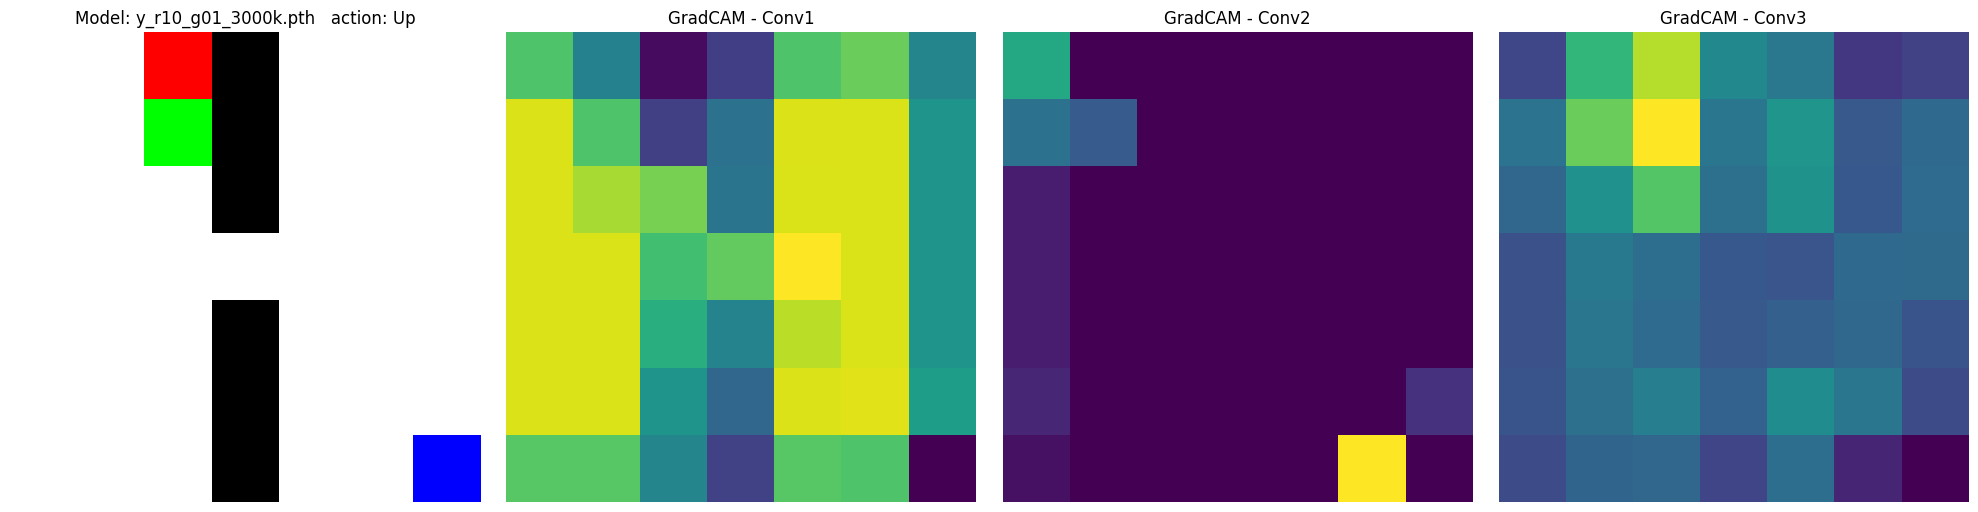

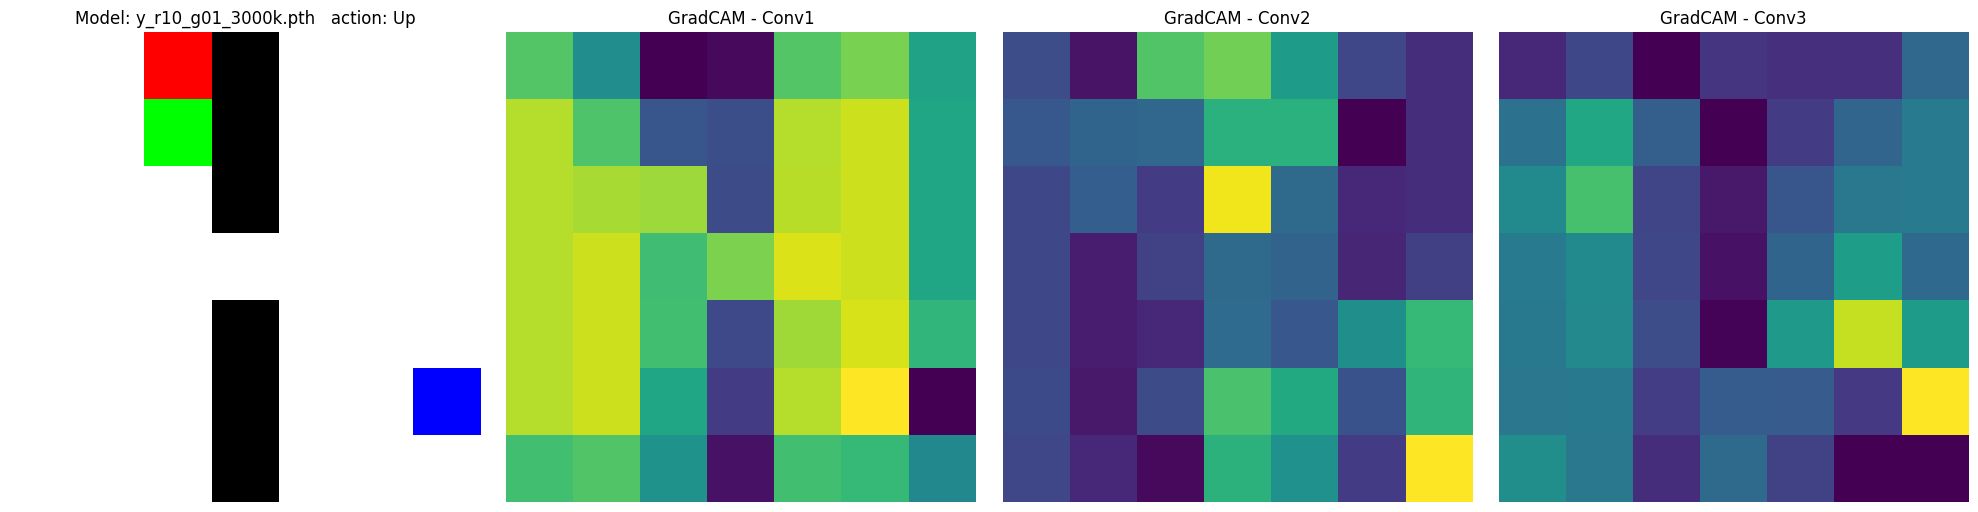

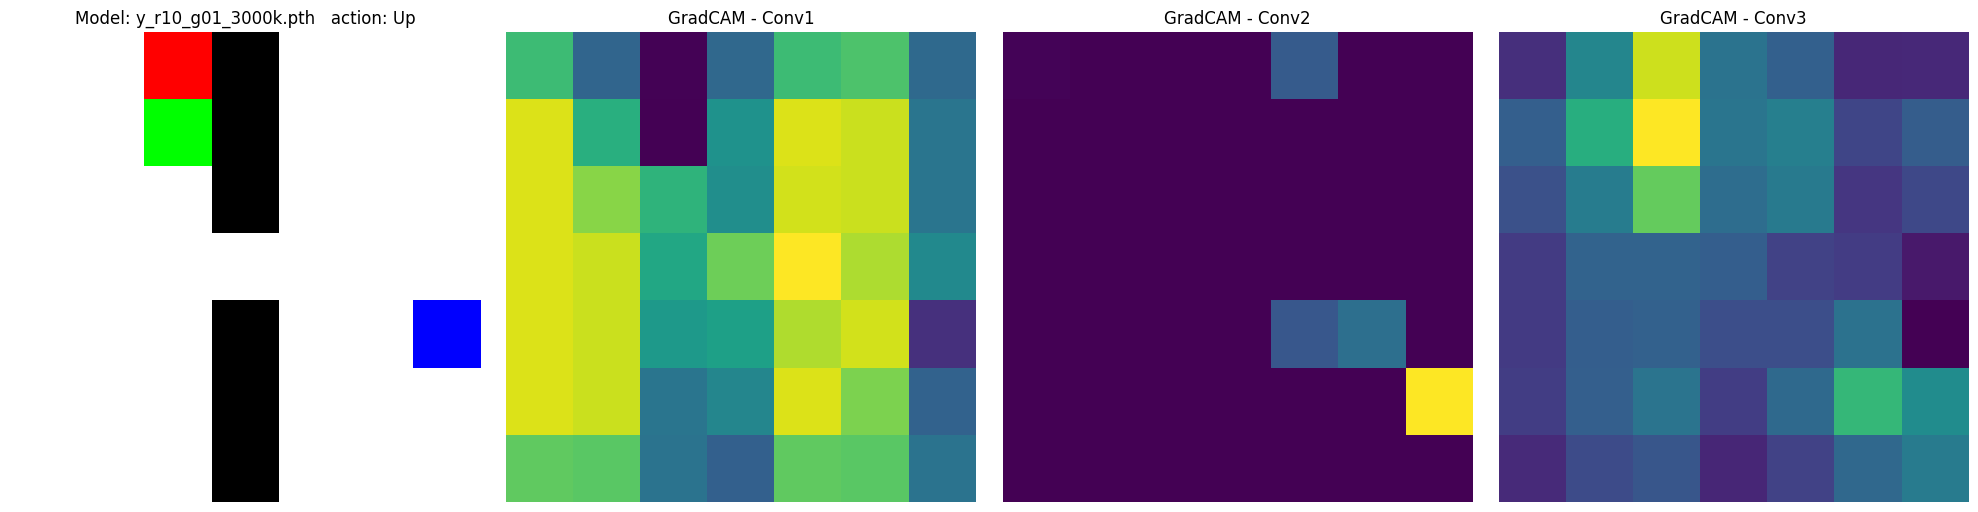

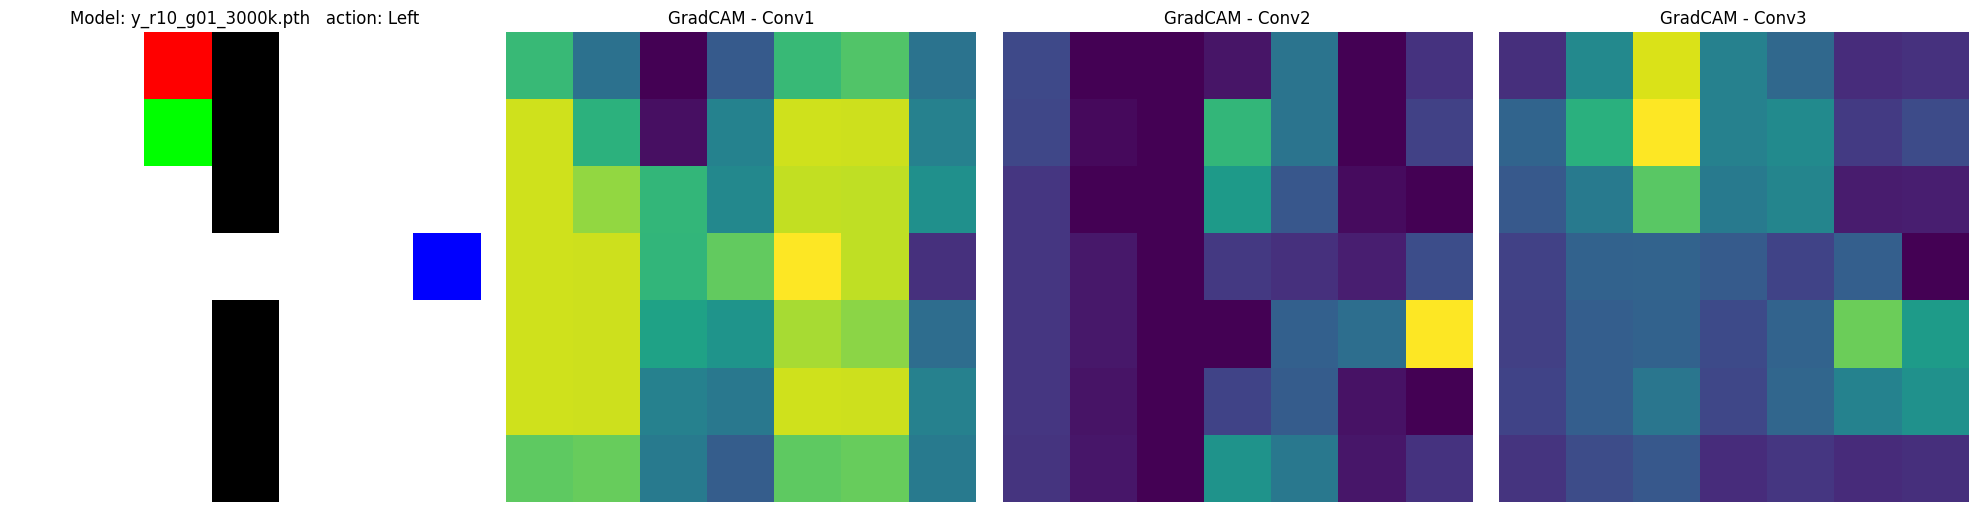

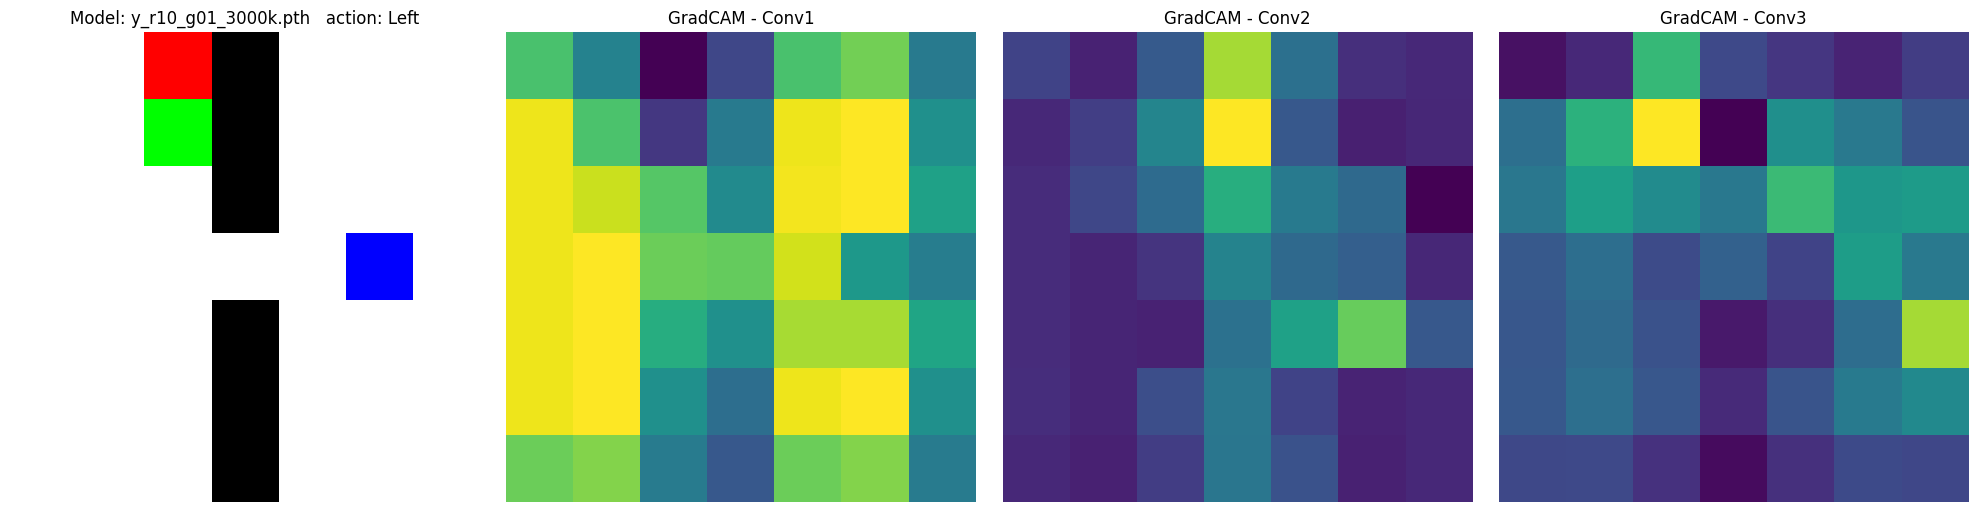

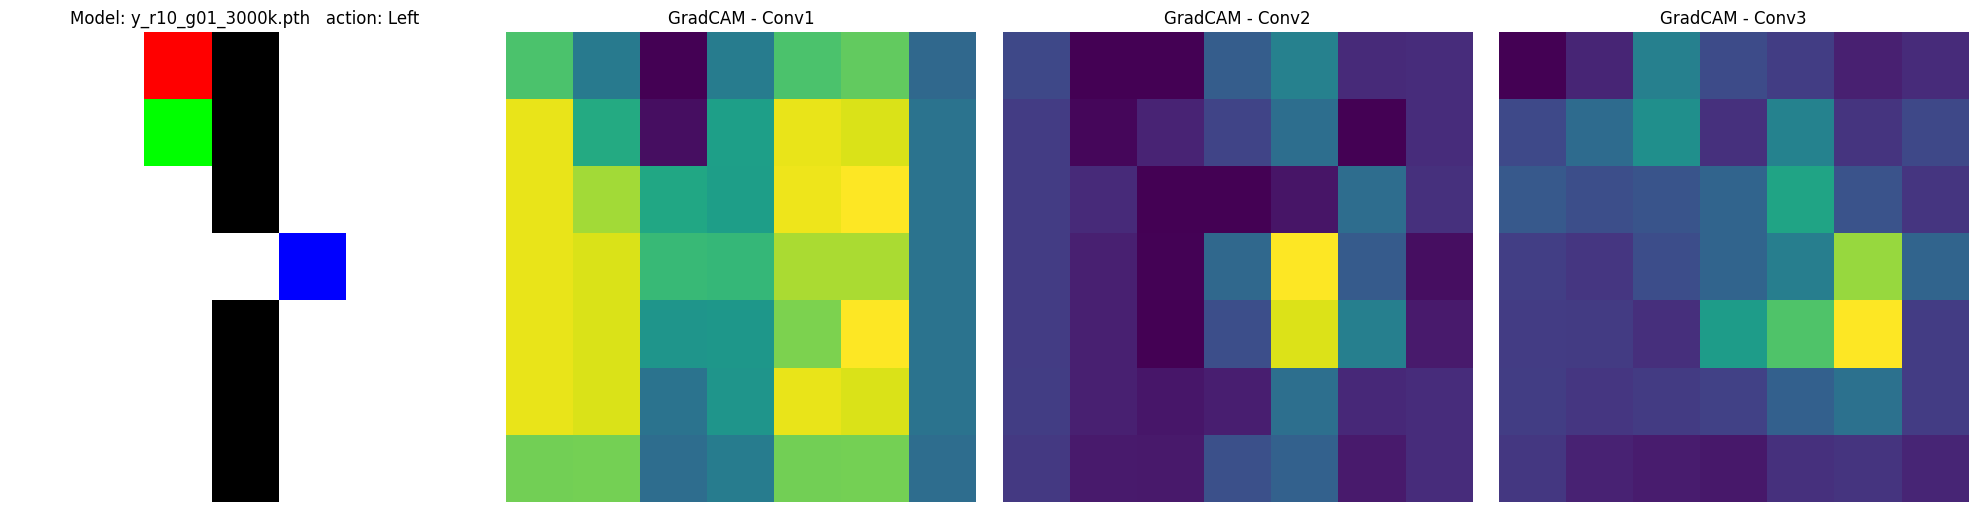

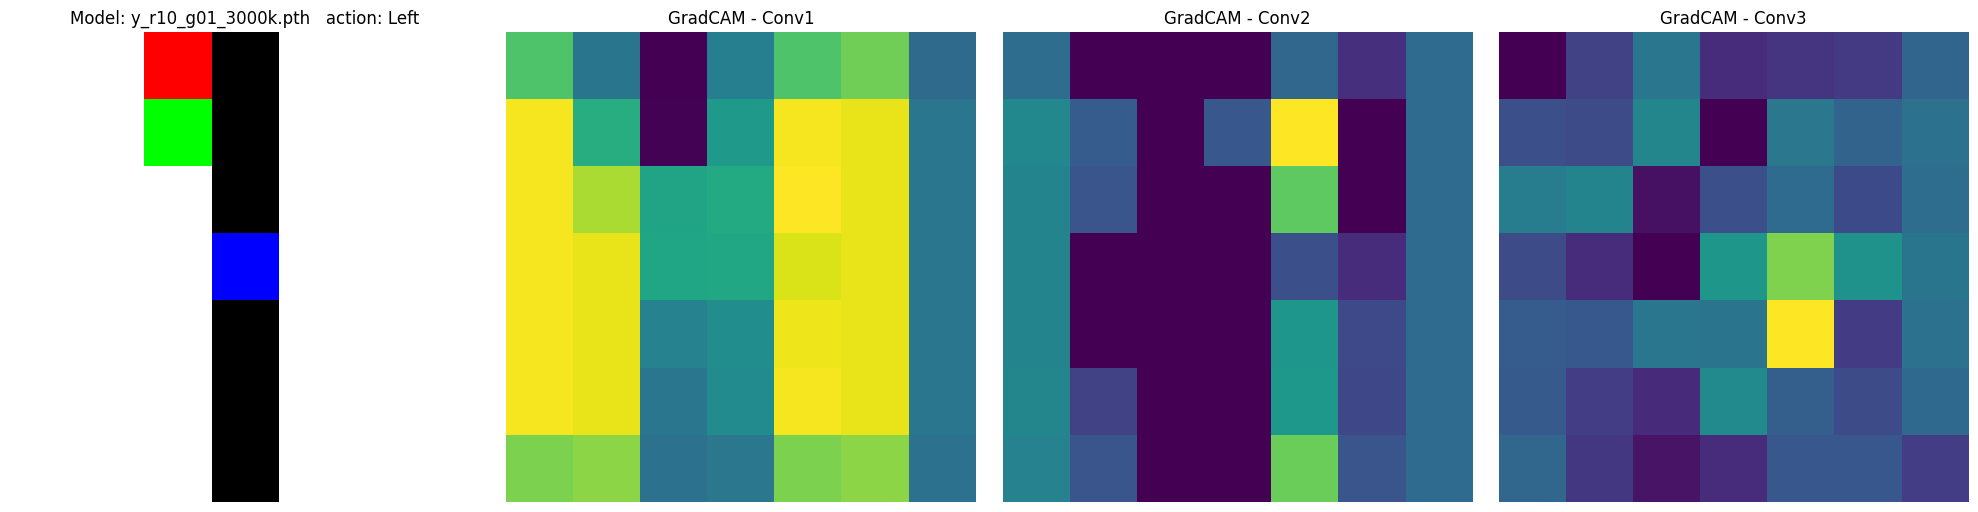

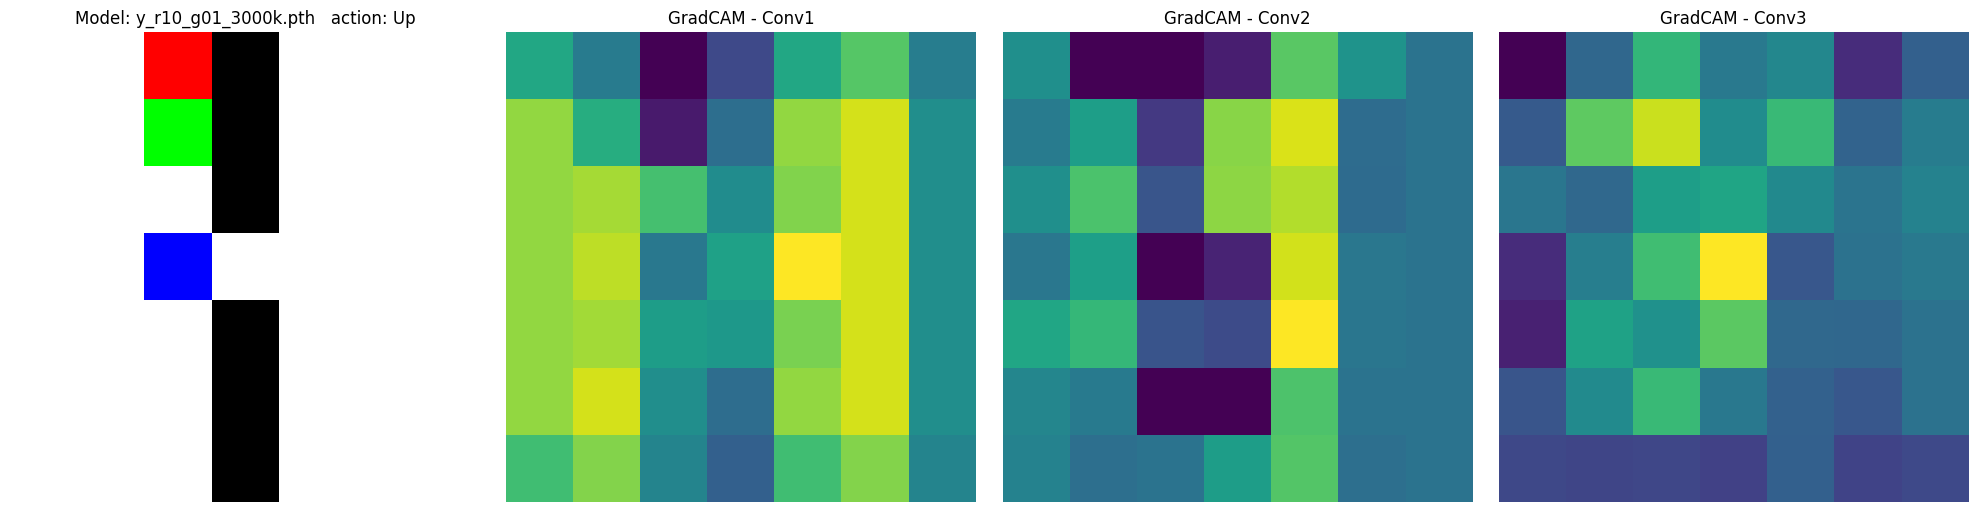

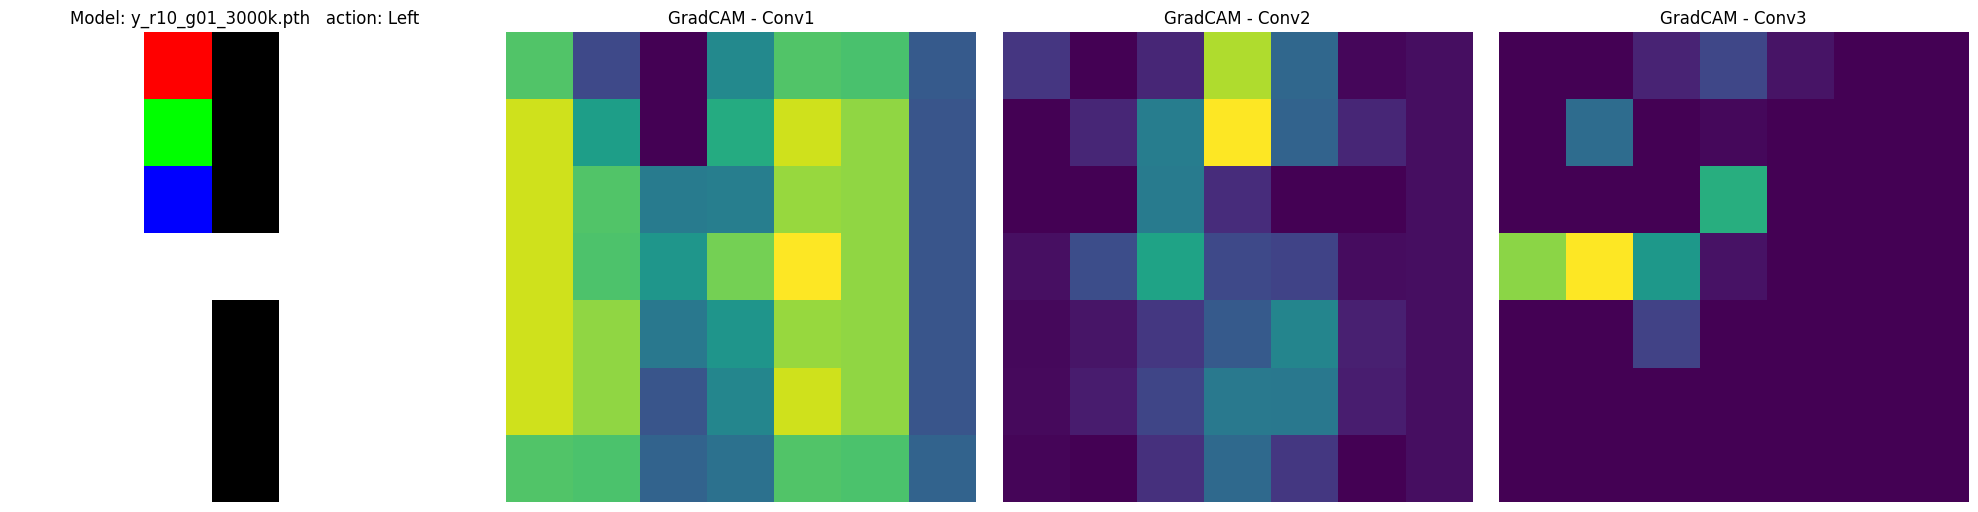

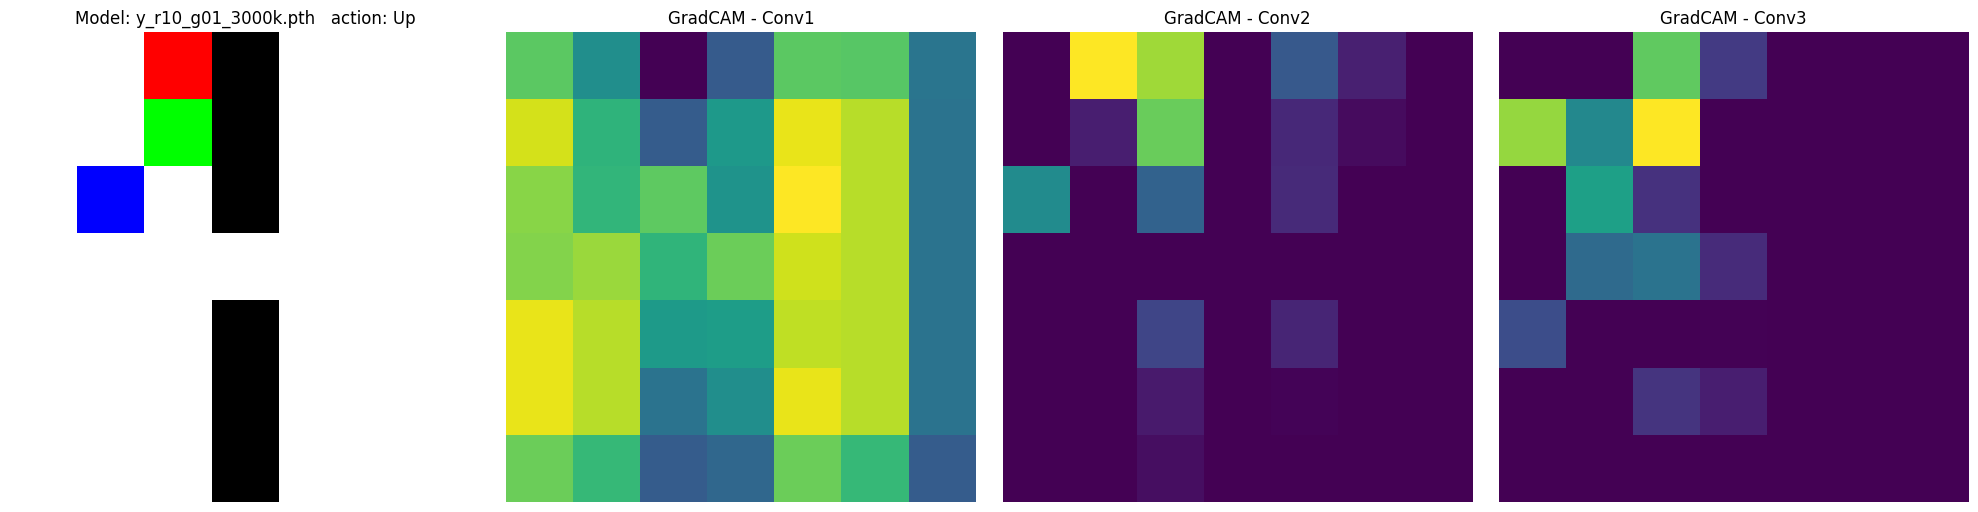

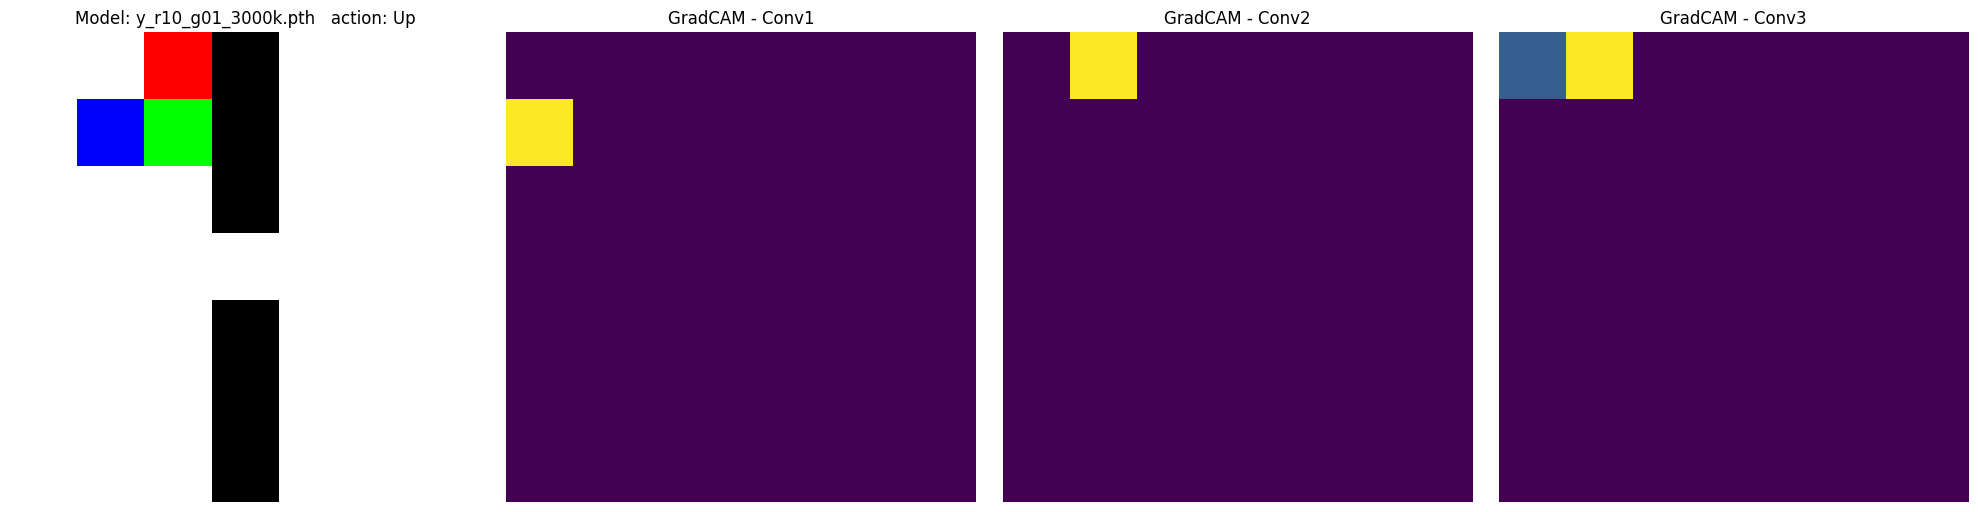

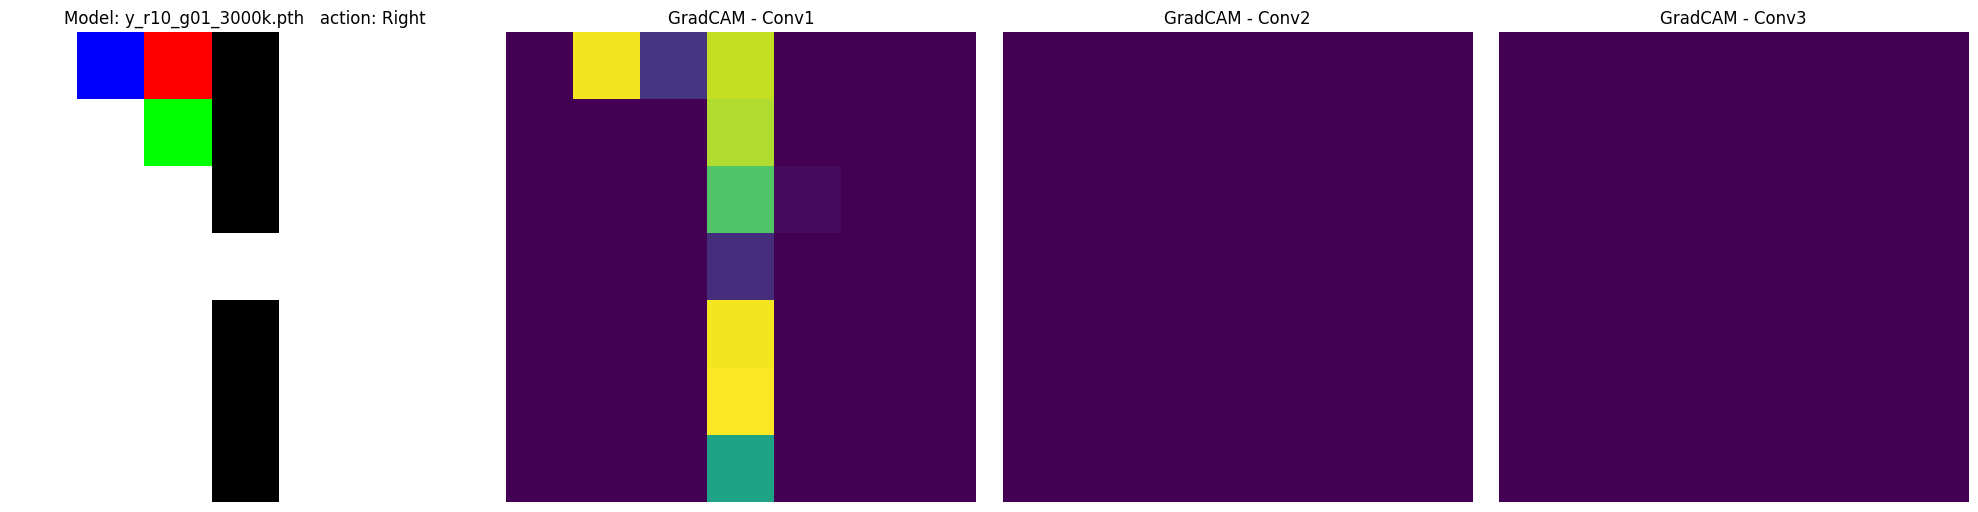

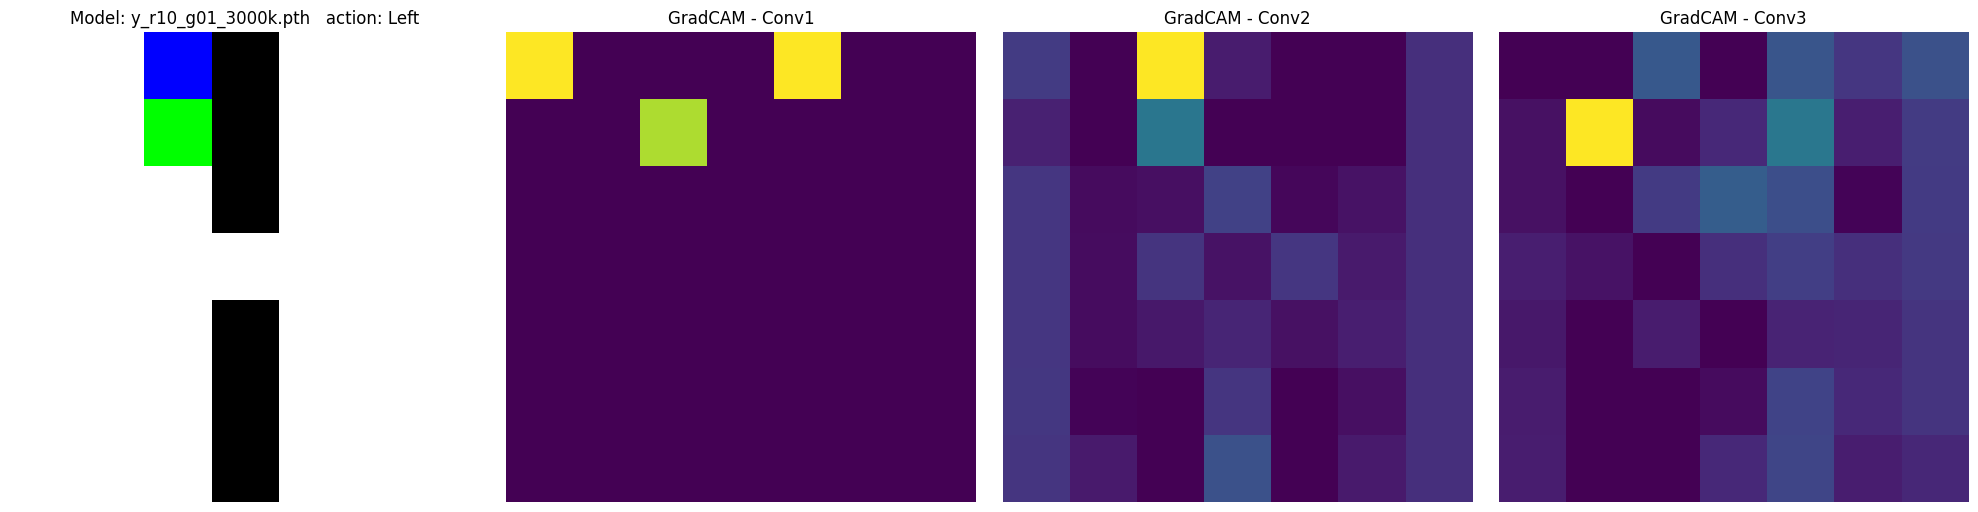

In [303]:
# An episode of only gradcam
#observation, _ = env.reset()

modelName = "y_r10_g01_3000k.pth"
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{modelName}")

state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
plot_gradcam(agent, observation, modelName)
terminated, truncated = False, False
while not terminated and not truncated:
    with torch.no_grad():
        action = agent.policy_net(state).max(1)[1].view(1, 1)
    next_state, reward, terminated, truncated, _ = env.step(action.item())
    state = torch.tensor(next_state, dtype=torch.float32, device=agent.device).unsqueeze(0)
    plot_gradcam(agent, next_state, modelName)

In [304]:
# def plot_SHAP()

gamestateDataset = pd.read_csv("C:/Projects/public/XAI_Master/datasets/42000_gamestates_oldDims.csv")
backgroundData = gamestateDataset.values.reshape(-1, 7, 7, 3).transpose((0, 3, 1, 2)) #given the old dims
backgroundData = torch.tensor(backgroundData, dtype=torch.float32)

def plot_SHAP(agent, state, action, backgroundData=backgroundData, batch_size = 64, sample_size = 10000, reduceDim=True, plot=True):
    backgroundData = backgroundData[np.random.choice(backgroundData.shape[0], sample_size, replace=False), :, :, :]
    explainer = shap.GradientExplainer(agent.policy_net, data=backgroundData, batch_size=batch_size)
        
    shap_values = explainer.shap_values(state)
    action_shap_values = np.array([s[:,:,:,action.item()] for s in shap_values]).squeeze(0).transpose(2, 1, 0)
    
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()
    if plot:
        shap.image_plot([action_shap_values], original_img, show=True)
    if reduceDim:
        action_shap_values = action_shap_values.max(axis=2)
    

    action_shap_values = (action_shap_values - action_shap_values.min()) / (action_shap_values.max() - action_shap_values.min())
    
    return action_shap_values

In [305]:
# Plot an episode of SHAP?


modelName = "y_r10_g01_3000k.pth"
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{modelName}")

#observation, _ = env.reset()
state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
action = agent.policy_net(state).max(1)[1].view(1, 1)


#shap_values = shap.DeepExplainer(agent.policy_net, backgroundData).shap_values(state, check_additivity=False)

# the following is for kernelExplainer
"""
original_shape = (3, 7, 7)  # shape expected by your policy_net
backgroundData = backgroundData.cpu().numpy().reshape((backgroundData.shape[0], -1))
state = state.cpu().numpy().reshape((state.shape[0], -1))
def model_wrapper(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    x_tensor = x_tensor.view(x.shape[0], *original_shape)  # reshape if needed
    with torch.no_grad():
        return agent.policy_net(x_tensor).numpy()
shap_values = shap.KernelExplainer(model_wrapper, data=backgroundData).shap_values(state)
shap_values = shap_values[0].transpose(1, 0)[action.item()].reshape(original_shape).transpose(2, 1, 0)  # Transpose to match the expected shape
shap.image_plot([shap_values], original_img, show=True)
"""

"""
print(f"Action: {action_to_direction[action.item()]}")
plot_SHAP(agent, state, action)
terminated, truncated = False, False

while not terminated and not truncated:
    print(f"Action: {action_to_direction[action.item()]}")
    with torch.no_grad():
        action = agent.policy_net(state).max(1)[1].view(1, 1)
    next_state, reward, terminated, truncated, _ = env.step(action.item())
    state = torch.tensor(next_state, dtype=torch.float32, device=agent.device).unsqueeze(0)
    plot_SHAP(agent, state, action)
"""

Model loaded: C:/Projects/public/XAI_Master/models/y_r10_g01_3000k.pth


'\nprint(f"Action: {action_to_direction[action.item()]}")\nplot_SHAP(agent, state, action)\nterminated, truncated = False, False\n\nwhile not terminated and not truncated:\n    print(f"Action: {action_to_direction[action.item()]}")\n    with torch.no_grad():\n        action = agent.policy_net(state).max(1)[1].view(1, 1)\n    next_state, reward, terminated, truncated, _ = env.step(action.item())\n    state = torch.tensor(next_state, dtype=torch.float32, device=agent.device).unsqueeze(0)\n    plot_SHAP(agent, state, action)\n'

In [306]:
def plot_gradcam(agent, state, action, relu=True, plot=True):
    model = agent.policy_net
    model.eval()

    # Containers for activations and gradients
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Register hooks
    handle_forward = model.conv3.register_forward_hook(forward_hook)
    handle_backward = model.conv3.register_full_backward_hook(backward_hook)

    # Forward pass
    state.requires_grad_()
    output = model(state)
    selected_q_value = output[0, action.item()]

    # Backward pass
    model.zero_grad()
    selected_q_value.backward()

    # Clean up hooks
    handle_forward.remove()
    handle_backward.remove()

    # Retrieve data
    activation = activations[0]  # [1, C, H, W]
    gradient = gradients[0]      # [1, C, H, W]

    # Compute weights and Grad-CAM
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activation).sum(dim=1, keepdim=True)
    if relu:
        cam = F.relu(cam).squeeze().cpu().transpose(1, 0).numpy()
    else:
        cam = cam.squeeze().cpu().transpose(1, 0).numpy()

    # Normalize CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Resize and overlay
    cam_resized = np.uint8(255 * cam)
    cam_colored = plt.cm.jet(cam_resized / 255.0)[..., :3]

    # Get original image
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()

    overlay = 0.5 * original_img + 0.5 * cam_colored
    overlay = np.clip(overlay, 0, 1)

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Grad-CAM")
        plt.imshow(cam)
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    return cam


In [307]:
def get_normalized_activation_maps(agent, state, plot=True):
    # Ensure we're in eval mode
    agent.policy_net.eval()
    
    activations = []

    # Hook functions to capture outputs
    def hook_fn(layer_acts):
        def hook(module, input, output):
            layer_acts.append(output)
        return hook

    # Register hooks for the 3 layers
    layer_outputs = []
    hooks = []
    for layer in (agent.policy_net.conv1, agent.policy_net.conv2, agent.policy_net.conv3):
        hooks.append(layer.register_forward_hook(hook_fn(layer_outputs)))

    # Run a forward pass
    with torch.no_grad():
        _ = agent.policy_net(state)

    # Remove hooks
    for h in hooks:
        h.remove()

    # Reduce each activation map to shape (7, 7) via mean over channels, and stack into final (7, 7, 3)
    activation_maps = []
    for act in layer_outputs:
        # Each 'act' is a tensor of shape (1, C, H, W)
        act = act[0]  # Remove batch dimension -> (C, H, W)
        avg_map = act.mean(dim=0)  # Mean over channels -> (H, W)
        avg_map_resized = F.interpolate(avg_map.unsqueeze(0).unsqueeze(0), size=(7, 7), mode='bilinear', align_corners=False)
        activation_maps.append(avg_map_resized.squeeze().cpu().numpy())

    # Stack along last dimension to shape (7, 7, 3)
    activation_stack = np.stack(activation_maps, axis=-1).transpose(1, 0, 2)
    
    # Normalize to [0, 1]
    activation_stack -= activation_stack.min()
    activation_stack /= activation_stack.max() + 1e-8

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(state[0].cpu().numpy().transpose(1, 0, 2))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Combined Activation Maps")

    return activation_stack


In [308]:
def plot_smoothgrad(agent, state, action, num_samples=50, noise_level=0.1, reduceDim=True, plot=True):
    model = agent.policy_net
    model.eval()

    grads = []

    for _ in range(num_samples):
        noise = torch.randn_like(state) * noise_level
        noisy_state = (state + noise).clamp(0, 1).detach().requires_grad_()  # ensure it's a leaf with grad tracking

        output = model(noisy_state)
        selected_q_value = output[0, action.item()]
        
        model.zero_grad()
        selected_q_value.backward()

        grads.append(noisy_state.grad.detach().clone())

    # Average the gradients
    smooth_grad = torch.stack(grads).mean(dim=0).abs()
    smooth_grad = smooth_grad.squeeze().cpu().permute(2, 1, 0).numpy()

    if reduceDim:
        smooth_grad = smooth_grad.max(axis=2)
    #else:
        
    # Normalize
    smooth_grad = (smooth_grad - smooth_grad.min()) / (smooth_grad.max() - smooth_grad.min() + 1e-8)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        original_img = state[0].detach().permute(1, 2, 0).cpu().numpy()
        plt.imshow(original_img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("SmoothGrad")
        plt.imshow(smooth_grad)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return smooth_grad



In [309]:
def plot_integrated_gradients(agent, state, action, baseline=None, steps=50, reduceDim=True, plot=True):
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()
    
    agent.policy_net.eval()

    if baseline is None:
        baseline = torch.zeros_like(state).to(state.device)
    assert baseline.shape == state.shape, "Baseline must have the same shape as input state"
    
    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (state - baseline) for i in range(1, steps + 1)]
    total_gradients = torch.zeros_like(state).to(state.device)

    for scaled_input in scaled_inputs:
        scaled_input.requires_grad_(True)
        scaled_input.retain_grad()  # 🔧 This ensures .grad will be populated
        q_values = agent.policy_net(scaled_input)
        selected_q_value = q_values[0, action.item()]
        selected_q_value.backward()
        total_gradients += scaled_input.grad
        scaled_input.grad = None


    # Average gradients and compute integrated gradients
    avg_gradients = total_gradients / steps
    integrated_gradients = (state - baseline) * avg_gradients
    ig = integrated_gradients.abs().squeeze().detach().cpu()

    if reduceDim:
        ig_map = ig.max(dim=0)[0]
        ig_map = ig_map.transpose(1, 0).numpy()
    else:
        ig_map = ig.numpy()
        ig_map = ig_map.transpose(2, 1, 0)
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min())

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img, interpolation='nearest')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Integrated Gradients")
        plt.imshow(ig_map, cmap='viridis', interpolation='nearest')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    return ig_map


In [310]:
# def plot_deeplift_map()
class QValueWrapper(torch.nn.Module):
    def __init__(self, model, action_index):
        super().__init__()
        self.model = model
        self.action_index = action_index

    def forward(self, x):
        q_values = self.model(x)
        return q_values[:, self.action_index].unsqueeze(1)

def plot_deeplift_map(agent, state, action, reduceDim=True, plot=True):
    
    
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Setting forward, backward hooks and attributes on non-linear activations.*")
    # Clone original image for display
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()

    agent.policy_net.eval()
    state = state.detach()

    state.requires_grad = True # To fix warning
    
    # Wrap model to return only the selected Q-value
    wrapped_model = QValueWrapper(agent.policy_net, action.item())

    # Define attribution method
    deeplift = DeepLift(wrapped_model)

    # Define a baseline (e.g., black image)
    baseline = torch.zeros_like(state)

    # Compute attributions
    # Temporarily suppress all UserWarnings (includes Captum's)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        attributions = deeplift.attribute(state, baselines=baseline)

    # Process attributions
    attribution = attributions.squeeze().cpu().abs()

    # Reduce to 2D
    if reduceDim:
        attribution_map = attribution.max(dim=0)[0]
        attribution_map = attribution_map.transpose(1, 0).detach().numpy()
    else:
        attribution_map = attribution.detach().numpy()
        attribution_map = attribution_map.transpose(2, 1, 0)

    # Convert safely to NumPy
    attribution_map = (attribution_map - attribution_map.min()) / (attribution_map.max() - attribution_map.min())

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img, interpolation='nearest')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("DeepLIFT Attribution")
        plt.imshow(attribution_map, cmap='viridis', interpolation='nearest')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    return attribution_map


In [311]:
# plot_guidedbackprop_map()
# GuidedReLU modifies ReLU to block negative gradients during backprop
class GuidedReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[grad_output < 0] = 0
        return grad_input

# Replace standard ReLU with GuidedReLU
class GuidedBackpropModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self._replace_relu_with_guided(self.model)

    def _replace_relu_with_guided(self, module):
        for name, submodule in module.named_children():
            if isinstance(submodule, nn.ReLU):
                setattr(module, name, GuidedReLUWrapper())
            else:
                self._replace_relu_with_guided(submodule)

    def forward(self, x):
        return self.model(x)

class GuidedReLUWrapper(nn.Module):
    def forward(self, x):
        return GuidedReLU.apply(x)

def plot_guidedbackprop_map(agent, state, action, reduceDim=True, plot=True):
    # Clone original image for display
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()

    agent.policy_net.eval()
    state = state.detach()
    state.requires_grad = True

    # Wrap model to return only the selected Q-value
    wrapped_model = QValueWrapper(agent.policy_net, action.item())

    # Wrap model with GuidedBackprop logic
    guided_model = GuidedBackpropModel(wrapped_model)

    # Forward pass
    output = guided_model(state)

    # Zero gradients and compute backward pass
    guided_model.zero_grad()
    output.backward(torch.ones_like(output))

    # Get gradients w.r.t input
    gradients = state.grad.detach().squeeze().cpu().abs()

    # Reduce to 2D
    if reduceDim:
        attribution_map = gradients.max(dim=0)[0]
        attribution_map = attribution_map.transpose(1, 0).detach().numpy()
    else:
        attribution_map = gradients.detach().numpy()
        attribution_map = attribution_map.transpose(2, 1, 0)
    attribution_map = (attribution_map - attribution_map.min()) / (attribution_map.max() - attribution_map.min())

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img, interpolation='nearest')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Guided Backprop Attribution")
        plt.imshow(attribution_map, cmap='viridis', interpolation='nearest')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return attribution_map


In [312]:
def plot_saliency_map(agent, state, action, reduceDim=True, plot=True):
    
    original_img = state[0].clone().detach().permute(2, 1, 0).cpu().numpy()
    # Make sure the model is in eval mode and gradients are enabled
    agent.policy_net.eval()
    state.requires_grad = True  # Enable gradient tracking

    # Forward pass
    q_values = agent.policy_net(state)

    # Select the Q-value for the chosen action
    selected_q_value = q_values[0, action.item()]

    # Backward pass to compute gradient w.r.t. input state
    selected_q_value.backward()

    # Get the gradient from the input
    saliency = state.grad.abs().squeeze().cpu()

    # If image input: [C, H, W], convert to 2D map via max across channels
    if reduceDim:
        saliency_map = saliency.max(dim=0)[0].transpose(1, 0).numpy()
    else:
        saliency_map = saliency.numpy().transpose(2, 1, 0)
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())  # Normalize to [0, 1]
    
    # Reset gradient for safety
    state.requires_grad_(False)
    state.grad = None

    if plot:
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img, interpolation='nearest')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Saliency Map")
        plt.imshow(saliency_map, cmap='viridis', interpolation='nearest')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    return saliency_map

In [313]:
def plotXaiMaps(agent, state, action, plot=True, plotsPerRow=5):
    plotDict = {
    f"Next action: {action_to_direction[action.item()]}": state[0].clone().detach().permute(2, 1, 0).cpu().numpy(),
    "activation maps": get_normalized_activation_maps(agent, state, plot=False),
    "SHAP": plot_SHAP(agent, state, action, reduceDim=False, plot=False),
    "saliency_map": plot_saliency_map(agent, state, action, reduceDim=False, plot=False),
    "gradcam": plot_gradcam(agent, state, action, relu=True, plot=False),
    "gradcam, no relu": plot_gradcam(agent, state, action, relu=False, plot=False),
    "int_gradients": plot_integrated_gradients(agent, state, action, reduceDim=False, plot=False),
    "deeplift": plot_deeplift_map(agent, state, action, reduceDim=False, plot=False),
    "guided_backprop": plot_guidedbackprop_map(agent, state, action, reduceDim=False, plot=False),
    "smoothgrad": plot_smoothgrad(agent, state, action, reduceDim=False, plot=False)
    }
    if plot:
        rows = (len(plotDict) + plotsPerRow - 1) // plotsPerRow  # Calculate rows
        cols = plotsPerRow
        plt.figure(figsize=(cols * 2, rows * 2))  # adjust the 2 to your preferred scale

        for i, (key, value) in enumerate(plotDict.items()):
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(value, cmap='viridis')
            ax.set_title(f"{key}", fontsize=10)

            # Remove ticks and numbers
            ax.set_xticks([])
            ax.set_yticks([])
            ax.tick_params(left=False, bottom=False)

            # Add a thin black border
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor('black')
                spine.set_linewidth(0.5)

        #plt.tight_layout(pad=0, h_pad=0, w_pad=0.5, rect=[0, 0, 1, 1])
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.show()
    
    return plotDict


Model loaded: C:/Projects/public/XAI_Master/models/y_r04_g10_3000k.pth


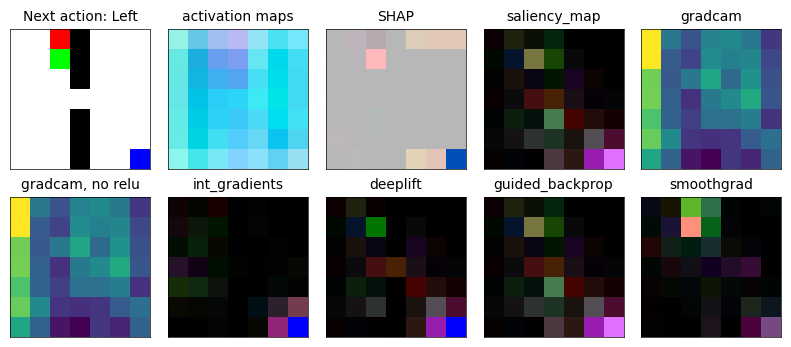

In [314]:
# An episode of all xai maps
modelName = "y_r04_g10_3000k.pth"
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{modelName}")

#observation, _ = env.reset()
state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
action = agent.policy_net(state).max(1)[1].view(1, 1)
"""
terminated, truncated = False, False
while not terminated and not truncated:
    with torch.no_grad():
        action = agent.policy_net(state).max(1)[1].view(1, 1)

    plotXaiMaps(agent, state, action)

    next_state, reward, terminated, truncated, _ = env.step(action.item())
    state = torch.tensor(next_state, dtype=torch.float32, device=agent.device).unsqueeze(0)
    state.requires_grad_()  # Enable gradients for saliency map
"""
plotDict = plotXaiMaps(agent, state, action)

Model loaded: C:/Projects/public/XAI_Master/models/y_r04_g10_3000k.pth
State, max: 0.9899426698684692, min: 0.005147457122802734, mean: 0.5167398452758789


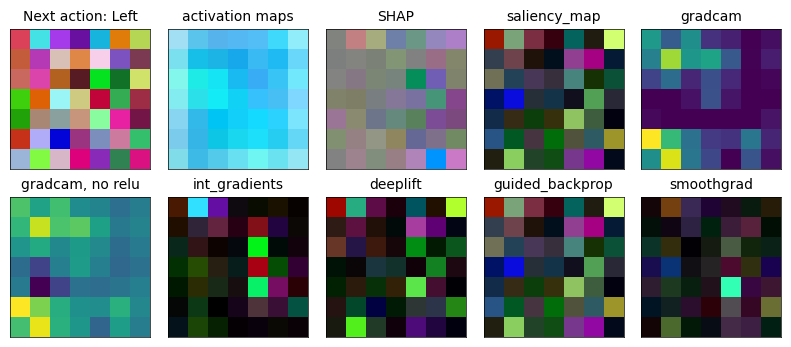

In [315]:
modelName = "y_r04_g10_3000k.pth"
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{modelName}")

#observation, _ = env.reset()
state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
rand_state = torch.rand((1, 3, 7, 7), dtype=torch.float32, device=agent.device)
print(f"State, max: {rand_state.max()}, min: {rand_state.min()}, mean: {rand_state.mean()}")
action = agent.policy_net(state).max(1)[1].view(1, 1)

plotDict = plotXaiMaps(agent, rand_state, action)

Model loaded: C:/Projects/public/XAI_Master/models/y_r04_g10_3000k.pth


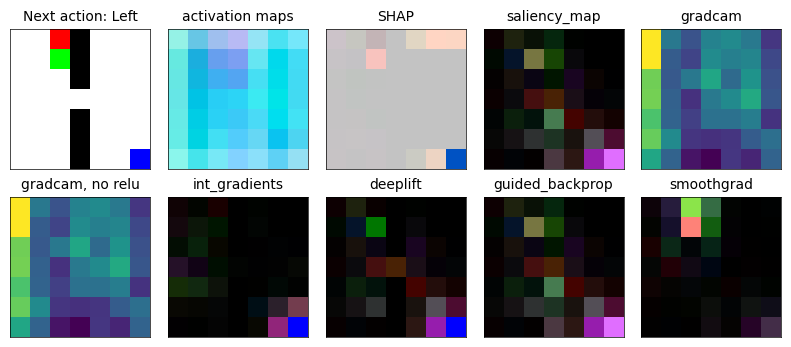

Map 0: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.837
Map 1: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.693
Map 2: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.751
Map 3: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.059
Map 4: (7, 7) - max: 1.00, min: 0.00, mean: 0.384
Map 5: (7, 7) - max: 1.00, min: 0.00, mean: 0.384
Map 6: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.047
Map 7: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.067
Map 8: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.102
Map 9: (7, 7, 3) - max: 1.00, min: 0.00, mean: 0.080
Next action: Left - shape: (7, 7, 3)
activation maps - shape: (7, 7, 3)
SHAP - shape: (7, 7, 3)
saliency_map - shape: (7, 7, 3)
gradcam - shape: (7, 7)
gradcam, no relu - shape: (7, 7)
int_gradients - shape: (7, 7, 3)
deeplift - shape: (7, 7, 3)
guided_backprop - shape: (7, 7, 3)
smoothgrad - shape: (7, 7, 3)


In [316]:
def getXaiMaps(agent, state, action):
    mapTuple = (
        state[0].clone().detach().permute(2, 1, 0).cpu().numpy(),
        get_normalized_activation_maps(agent, state, plot=False),
        plot_SHAP(agent, state, action, reduceDim=False, plot=False),
        plot_saliency_map(agent, state, action, reduceDim=False, plot=False),
        plot_gradcam(agent, state, action, relu=True, plot=False),
        plot_gradcam(agent, state, action, relu=False, plot=False),
        plot_integrated_gradients(agent, state, action, reduceDim=False, plot=False),
        plot_deeplift_map(agent, state, action, reduceDim=False, plot=False),
        plot_guidedbackprop_map(agent, state, action, reduceDim=False, plot=False),
        plot_smoothgrad(agent, state, action, reduceDim=False, plot=False)
    )
    return mapTuple

modelName = "y_r04_g10_3000k.pth"
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{modelName}")

#observation, _ = env.reset()
state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
action = agent.policy_net(state).max(1)[1].view(1, 1)

plotDict = plotXaiMaps(agent, state, action)
mapTuple = getXaiMaps(agent, state, action)

for i, map in enumerate(mapTuple):
    print(f"Map {i}: {map.shape} - max: {map.max():.2f}, min: {map.min():.2f}, mean: {map.mean():.3f}")

for i, (key, value) in enumerate(plotDict.items()):
    print(f"{key} - shape: {value.shape}")

In [317]:
#def createDataset(agent, env, model, rows, steps):
# Or rather export methods to run through DnqAgent???

In [323]:
stepsPerEpisode = 7 # ie from 0 including 6
episodesPerDataset = 2

for i, name in enumerate(modelNamesTrain):
    timestart = time.time()
    #agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/{name}.pth")
    agent.printProgress(timeStart=timestart, percent=i/len(train_dict)) 
 
    df = pd.DataFrame(columns=["target"] + ["stepsTaken"]
                        + [f'pix{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']]
                        + [f'act{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # activation maps
                        + [f'shap{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # shap values
                        + [f'gc{i}{j}' for i in range(7) for j in range(7)] # gradcam
                        + [f'gcnr{i}{j}' for i in range(7) for j in range(7)] # gradcam, no relu
                        + [f'sal{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # saliency map
                        + [f'ig{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # integrated gradients
                        + [f'dl{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # deeplift
                        + [f'gb{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # guided backprop
                        + [f'sg{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']]) # smoothgrad

    for episodeNum in range(episodesPerDataset):
        """
        Data:
        Next action: Up - shape: (7, 7, 3)
        activation maps - shape: (7, 7, 3)
        SHAP - shape: (7, 7, 3)
        gradcam - shape: (7, 7)
        gradcam, no relu - shape: (7, 7)
        saliency_map - shape: (7, 7, 3)
        int_gradients - shape: (7, 7, 3)
        deeplift - shape: (7, 7, 3)
        guided_backprop - shape: (7, 7, 3)
        smoothgrad - shape: (7, 7, 3)
        """

        
        
        # initialise env 
        #observation, _ = env.reset() 
        state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0) 
        episode_df = pd.DataFrame(columns=["target"] + ["stepsTaken"]
                + [f'pix{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']]
                + [f'act{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # activation maps
                + [f'shap{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # shap values
                + [f'gc{j}{i}' for i in range(7) for j in range(7)] # gradcam
                + [f'gcnr{i}{j}' for i in range(7) for j in range(7)] # gradcam, no relu
                + [f'sal{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # saliency map
                + [f'ig{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # integrated gradients
                + [f'dl{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # deeplift
                + [f'gb{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']] # guided backprop
                + [f'sg{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']]) # smoothgrad

        episodeSteps = 0
        terminated, truncated = False, False 
        while not terminated and not truncated:

            if episodeSteps < stepsPerEpisode: # from 0 including 6
                with torch.no_grad(): 
                    action = agent.policy_net(state).max(1)[1].view(1, 1)
                xaiMaps = getXaiMaps(agent, state, action)
                #episode_df.loc[episodeSteps] = [0] + [episodeSteps] + list(state.flatten().detach().numpy()) + list(activationData) + list(action_shap_values.flatten()) + list(grayscaleGradCAM.flatten()) + list(grayscaleXGradCAM.flatten()) + list(grayscaleGradCAMplusPlus.flatten())
                episode_df.loc[episodeSteps] = [0] + [episodeSteps] +\
                    list(xaiMaps[0].flatten()) +\
                    list(xaiMaps[1].flatten()) +\
                    list(xaiMaps[2].flatten()) +\
                    list(xaiMaps[3].flatten()) +\
                    list(xaiMaps[4].flatten()) +\
                    list(xaiMaps[5].flatten()) +\
                    list(xaiMaps[6].flatten()) +\
                    list(xaiMaps[7].flatten()) +\
                    list(xaiMaps[8].flatten()) +\
                    list(xaiMaps[9].flatten())
                episodeSteps += 1
                print(f"episodedf: {episode_df.shape}, episodeSteps: {episodeSteps}, action: {action.item()}")
                
            if np.random.rand() < epsilon_min:
                action = torch.tensor([[random.randrange(agent.action_space.n)]], device=agent.device, dtype=torch.long)
            else:
                with torch.no_grad():
                    action = agent.policy_net(state).max(1)[1].view(1, 1)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=agent.device)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=agent.device).unsqueeze(0)
            state = next_state
        if terminated:
            target = reward.item()          # 1 reward ---> green chest
        else:                               # -1 reward ---> red chest
            target = 0                      # 0 truncated --> no chest
        # set target in all rows in episode_df to target
        episode_df["target"] = target
        # append episode_df to df
        if not episode_df.empty and not episode_df.isna().all(axis=None):
            warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame concatenation with empty or all-NA entries.*")
            df = pd.concat([df, episode_df], ignore_index=True)
        else:
            print(f"episodeNum {episodeNum} had a NaN :(")
        # episode finished, set target and save to df
    break


df

episodedf: (1, 1276), episodeSteps: 1, action: 2
episodedf: (1, 1276), episodeSteps: 1, action: 2


,target,stepsTaken,pix00r,pix00g,pix00b,pix01r,pix01g,pix01b,pix02r,pix02g,...,sg63b,sg64r,sg64g,sg64b,sg65r,sg65g,sg65b,sg66r,sg66g,sg66b
0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.082365,0.009804,0.011806,0.009057,0.262519,0.023731,0.237163,0.431990,0.258717,0.471793
1,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.093393,0.015570,0.023202,0.022725,0.371333,0.048918,0.358574,0.601511,0.291025,0.659765


Row 0 - target: 0, stepsTaken: 0.0


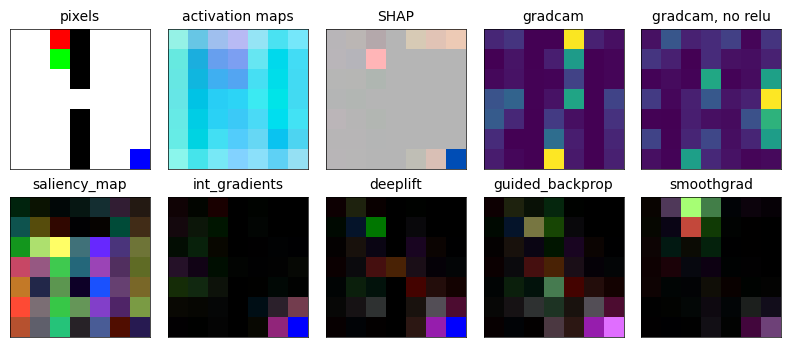

{'pixels': array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [0., 1., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [0., 0., 0.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
      

In [326]:
rowToPrint = 0
columnsNames = ([f'pix{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']],
                [f'act{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # activation maps
                [f'shap{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # shap values
                [f'gc{i}{j}' for i in range(7) for j in range(7)], # gradcam
                [f'gcnr{i}{j}' for i in range(7) for j in range(7)], # gradcam, no relu
                [f'sal{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # saliency map
                [f'ig{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # integrated gradients
                [f'dl{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # deeplift
                [f'gb{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']], # guided backprop
                [f'sg{i}{j}{c}' for i in range(7) for j in range(7) for c in ['r','g','b']]) # smoothgrad)

def plotDfRows(df, columnsNames, rows=1, plot=True, plotsPerRow=5):
    for row in range(rows):
        print(f"Row {row} - target: {df.iloc[row]['target']}, stepsTaken: {df.iloc[row]['stepsTaken']}")

        plotDict = {
        "pixels": np.array(df.iloc[row][columnsNames[0]], dtype=np.float32).reshape(7, 7, 3),
        "activation maps": np.array(df.iloc[row][columnsNames[1]], dtype=np.float32).reshape(7, 7, 3),
        "SHAP": np.array(df.iloc[row][columnsNames[2]], dtype=np.float32).reshape(7, 7, 3),
        "gradcam": np.array(df.iloc[row][columnsNames[3]], dtype=np.float32).reshape(7, 7),
        "gradcam, no relu": np.array(df.iloc[row][columnsNames[4]], dtype=np.float32).reshape(7, 7).transpose(1, 0),
        "saliency_map": np.array(df.iloc[row][columnsNames[5]], dtype=np.float32).reshape(7, 7, 3),
        "int_gradients": np.array(df.iloc[row][columnsNames[6]], dtype=np.float32).reshape(7, 7, 3),
        "deeplift": np.array(df.iloc[row][columnsNames[7]], dtype=np.float32).reshape(7, 7, 3),
        "guided_backprop": np.array(df.iloc[row][columnsNames[8]], dtype=np.float32).reshape(7, 7, 3),
        "smoothgrad": np.array(df.iloc[row][columnsNames[9]], dtype=np.float32).reshape(7, 7, 3)
        }

        if plot:
            rows = (len(plotDict) + plotsPerRow - 1) // plotsPerRow  # Calculate rows
            cols = plotsPerRow
            plt.figure(figsize=(cols * 2, rows * 2))  # adjust the 2 to your preferred scale

            for i, (key, value) in enumerate(plotDict.items()):
                ax = plt.subplot(rows, cols, i + 1)
                ax.imshow(value, cmap='viridis')
                ax.set_title(f"{key}", fontsize=10)

                # Remove ticks and numbers
                ax.set_xticks([])
                ax.set_yticks([])
                ax.tick_params(left=False, bottom=False)

                # Add a thin black border
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_edgecolor('black')
                    spine.set_linewidth(0.5)

            #plt.tight_layout(pad=0, h_pad=0, w_pad=0.5, rect=[0, 0, 1, 1])
            plt.subplots_adjust(wspace=0.1, hspace=0.2)
            plt.show()
    
    return plotDict

plotDfRows(df, columnsNames, rows=1, plot=True, plotsPerRow=5)